In [27]:
%run ./imports_models.py
%run ./dataset_preparation_v2.ipynb
%run -i ./utils.py

Stored 'df_complete' (DataFrame)
Stored 'df_grouped_dates' (DataFrame)
Stored 'series_grouped_dates' (Series)
Stored 'pandas_dataframe_groupby_site' (DataFrameGroupBy)
Stored 'sites_names' (list)


In [2]:
PATH_SERIALIZER = './../serialized_files/'

# Data per site

In [3]:
%store -r df_grouped_dates
%store -r series_grouped_dates
%store -r pandas_dataframe_groupby_site
%store -r sites_names

# Prepare Timeseries, Train and Forecast by group

* If all_sites is <strong>False</strong>, just one model will be trained with the specific group selected in site_index. 
* If all_sites is <strong>True</strong>, multiple models will be trained for all groups in dataset.

In [28]:
all_sites = True
site_index = 106
sites = []

if all_sites:
    sites = sites_names[:4]
else:
    sites = [sites_names[site_index]]

In [29]:
groups_info = {'timeseries':[],
               'tuning_results':[],
               'models':[],
               'cross_validation_results':[],
               'forecasts':[]}
exec_times_info = {'tuning_exec_times':[],
                   'training_exec_times':[],
                   'cross_validation_exec_times':[],
                   'forecast_exec_times':[]}
overall_exec_time = 0

In [26]:
if not all_sites:
    print('Training and forecasting %s ...\n'%sites_names[site_index])
else:
    print('Trainig and forecasting multiple time series groups...\n')

start_time_overall = time.time()
for site in tqdm(sites, desc="Overall: "):
    print('\033[1m' + 'Group %s'%(site) + '\033[0m')
    site_complete_data = pandas_dataframe_groupby_site.get_group(site)
    site_df_grouped_dates = prepare_timeserie_df(site_complete_data)
    site_df_data_train = site_df_grouped_dates[:16790]
    site_df_data_test = site_df_grouped_dates[16790:]
    groups_info['timeseries'].append(site_df_grouped_dates)
    
    
    print('Tuning...')
    start_time_tuning = time.time()
    site_tuning_results = hyperparameter_tuning(site_df_data_train, site)
    tuning_exec_time = time.time() - start_time_tuning
    print("--- Tuning ended at %s seconds ---" % (tuning_exec_time))
    groups_info['tuning_results'].append(site_tuning_results)
    
    
    print('Training model...')
    start_time_training = time.time()
    prophet_instance = Prophet(yearly_seasonality=True, 
                               weekly_seasonality=True,
                               seasonality_prior_scale=site_tuning_results[0],
                               changepoint_prior_scale=site_tuning_results[1],
                               daily_seasonality=site_tuning_results[2],
                               interval_width=0.95)
    prophet_instance.add_seasonality(name='monthly', 
                                     period=30.5, 
                                     fourier_order=5, 
                                     prior_scale=0.02)

    prophet_instance.fit(site_df_data_train)
    training_exec_time = time.time() - start_time_training
    print("--- Training ended at %s seconds ---" % (training_exec_time))
    groups_info['models'].append(prophet_instance)
    
    
    print('Cross validation...')
    start_time_cross_validation = time.time()
    site_cross_validation_results = cross_validation(prophet_instance, horizon='2760 hours')
    cross_validation_exec_time = time.time() - start_time_cross_validation
    print("--- Cross validation ended at %s seconds ---" % (cross_validation_exec_time))
    groups_info['cross_validation_results'].append(site_cross_validation_results)
    
    
    print('Forecasting...')
    start_time_forecast = time.time()
    site_forecast = prophet_instance.predict(site_df_data_test)
    forecast_exec_time = time.time() - start_time_forecast
    print("--- Forecast ended at %s seconds ---\n" % (forecast_exec_time))
    groups_info['forecasts'].append(site_forecast)
    
    
    exec_times_info['tuning_exec_times'].append(tuning_exec_time)
    exec_times_info['training_exec_times'].append(training_exec_time)
    exec_times_info['cross_validation_exec_times'].append(cross_validation_exec_time)
    exec_times_info['forecast_exec_times'].append(forecast_exec_time)
    
    
    
overall_exec_time = time.time() - start_time_overall
print("Multiple Training and Forecasting ended at--- %s seconds ---" % (overall_exec_time))

Training and forecasting CB-EHE: CardAdminAt-PR-EX ...



Overall:   0%|          | 0/1 [00:00<?, ?it/s]

Group S&C-PAD: REExecSvcs-PU
Tuning...


Tuning: S&C-PAD: REExecSvcs-PU:   0%|          | 0/16 [00:00<?, ?it/s]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-01-20 23:00:00 and 2019-09-07 23:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000192287F6C88>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-01-20 23:00:00 and 2019-09-07 23:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000019228F90AC8>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-01-20 23:00:00 and 2019-09-07 23:00:00
INFO:fbprophet:Applying in parallel with <concurrent.

KeyboardInterrupt: 

In [9]:
groups_info['tuning_results']

[(1    0.1
  Name: seasonality_prior_scale, dtype: float64,
  1    0.001
  Name: changepoint_prior_scale, dtype: float64)]

# Execution times info

Times for each group (unit: segs)

In [10]:
pd.DataFrame(exec_times_info)

,tuning_exec_times,training_exec_times,cross_validation_exec_times,forecast_exec_times
0,1916.852498,5.631967,38.74843,6.219395


Overall groups execution time (unit: segs)

In [11]:
overall_exec_time

1967.512103319168

# Load group info

In [12]:
print('%s has been selected'%sites_names[site_index])
if not all_sites:
    site_index = 0
    
cross_validation_results = groups_info['cross_validation_results'][site_index]
forecast_site = groups_info['forecasts'][site_index]
df_data_site = groups_info['timeseries'][site_index]
df_data_train_site = df_data_site[:16790]
df_data_test_site = df_data_site[16790:]
y_true = df_data_test_site['y']

S&C-PAD: REExecSvcs-PU has been selected


# Training evaluation metrics

In [13]:
cross_validation_results_no_negative = replace_negative_values_with_ceros(cross_validation_results.copy())

performance_metrics_training = get_performance_metrics_training(cross_validation_results_no_negative)
mse_mean_training_no_negative = performance_metrics_training[0]
rmse_mean_training_no_negative = performance_metrics_training[1]
mae_mean_training_no_negative = performance_metrics_training[2]

INFO:fbprophet:Skipping MAPE because y close to 0


In [14]:
training_performace_site = pd.DataFrame({'mse_mean_training':mse_mean_training_no_negative, 
                                         'rmse_mean_training':rmse_mean_training_no_negative, 
                                         'mae_mean_training':mae_mean_training_no_negative},
                                          index=[0])
training_performace_site

,mse_mean_training,rmse_mean_training,mae_mean_training
0,0.009833,0.099094,0.070285


# Forecast evaluation metrics

In [15]:
y_pred_no_negative = replace_negative_values_with_ceros(forecast_site.copy(), forecast_df=True)
performance_metrics_forecast = get_performance_metrics_forecast(y_true, y_pred_no_negative)
mae_forecast_no_negative = performance_metrics_forecast[0]
mse_forecast_no_negative = performance_metrics_forecast[1]
rmse_forecast_no_negative = performance_metrics_forecast[2]

In [16]:
forecast_performace_site = pd.DataFrame({'mse_forecast_site':mse_forecast_no_negative, 
                                         'rmse_forecast_site':rmse_forecast_no_negative, 
                                         'mae_forecast_site':mae_forecast_no_negative},
                                          index=[0])
forecast_performace_site

,mse_forecast_site,rmse_forecast_site,mae_forecast_site
0,0.094884,0.067133,0.009003


# Plots by site

In [17]:
y_pred_df_site = forecast_site[['ds','yhat']].copy()
y_pred_df_site['yhat'] = y_pred_no_negative
y_pred_df_site.index = series_grouped_dates[16790:].index
y_true_df_site = df_data_test_site.copy()
y_true_df_site['ds'] = pd.to_datetime(y_true_df_site['ds'])
y_true_df_site.index = series_grouped_dates[16790:].index

### Plot per year

Text(0.5, 1.0, 'Year 2020')

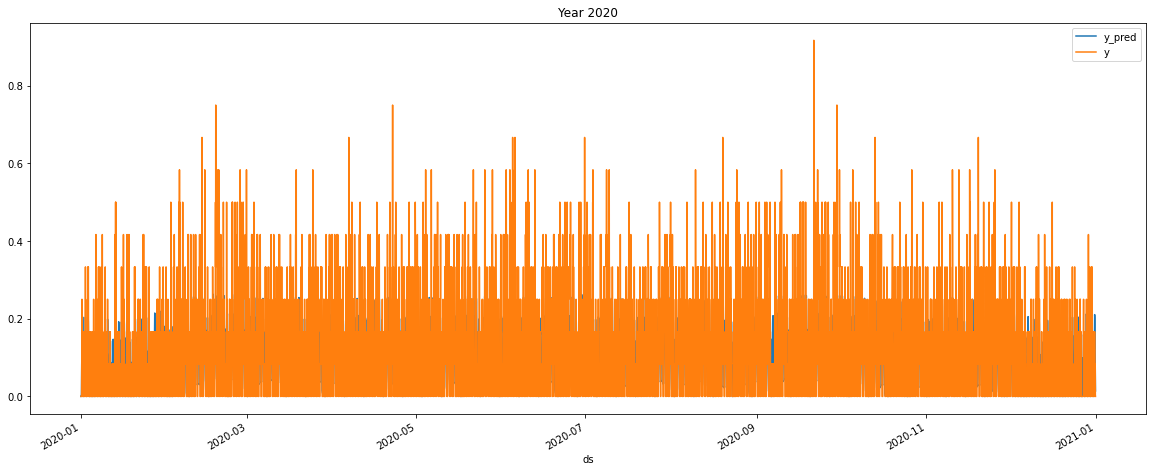

In [18]:
init_date = '2020-01-01'
end_date = '2020-12-31'
ax_2020=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_2020)
plt.title('Year 2020')

### Plots per month

Text(0.5, 1.0, 'January\n 2020-01-01 to 2020-01-31')

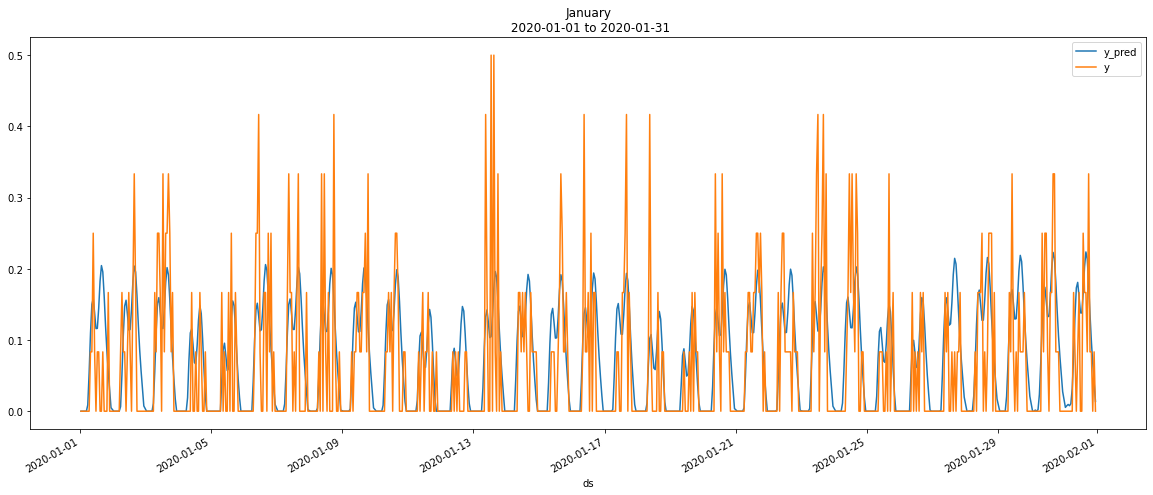

In [19]:
init_date = '2020-01-01'
end_date = '2020-01-31'
ax_jan=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_jan)
plt.title('January\n %s to %s'%(init_date, end_date))

Text(0.5, 1.0, 'May\n 2020-05-01 to 2020-05-31')

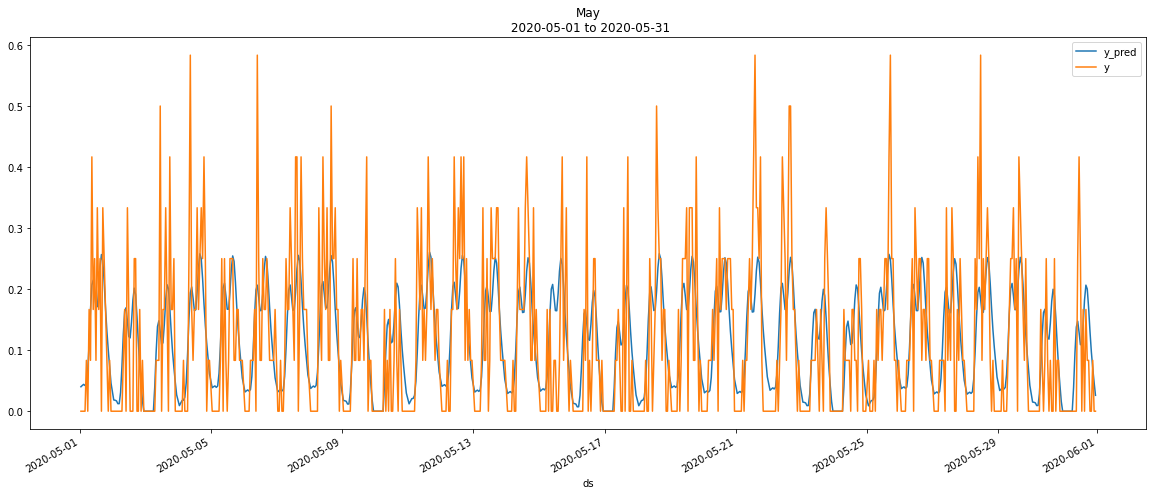

In [20]:
init_date = '2020-05-01'
end_date = '2020-05-31'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May\n %s to %s'%(init_date, end_date))

Text(0.5, 1.0, 'July\n 2020-07-01 to 2020-07-31')

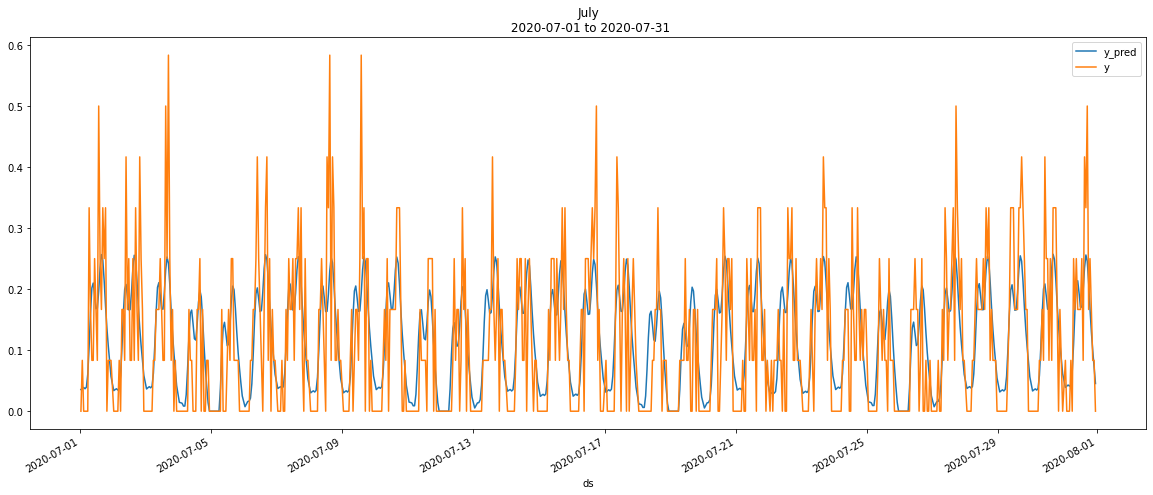

In [21]:
init_date = '2020-07-01'
end_date = '2020-07-31'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('July\n %s to %s'%(init_date, end_date))

### Plots per week

Text(0.5, 1.0, 'May\n 2020-05-04 to 2020-05-11')

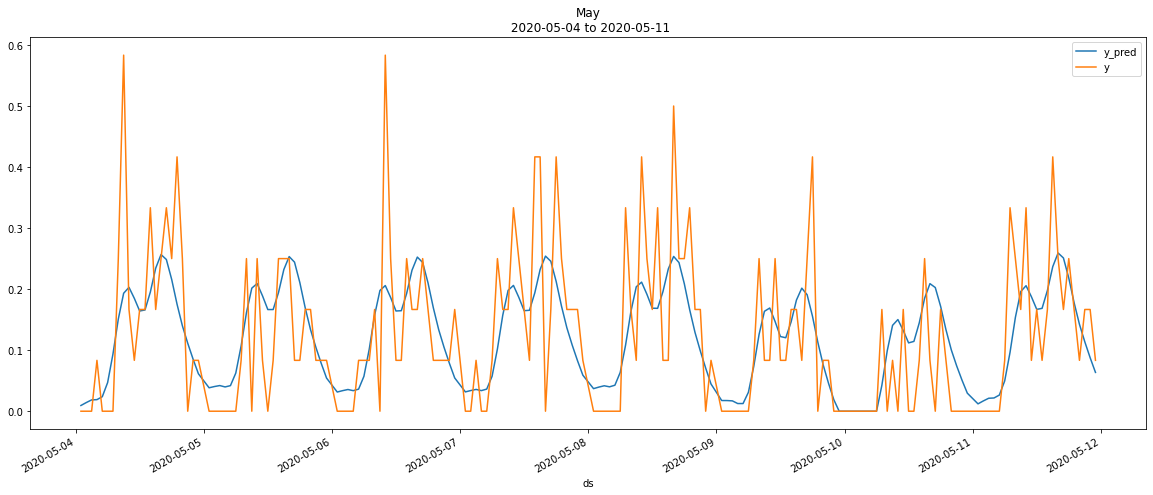

In [43]:
init_date = '2020-05-04'
end_date = '2020-05-11'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May\n %s to %s'%(init_date, end_date))

Text(0.5, 1.0, 'May\n 2020-05-18 to 2020-05-25')

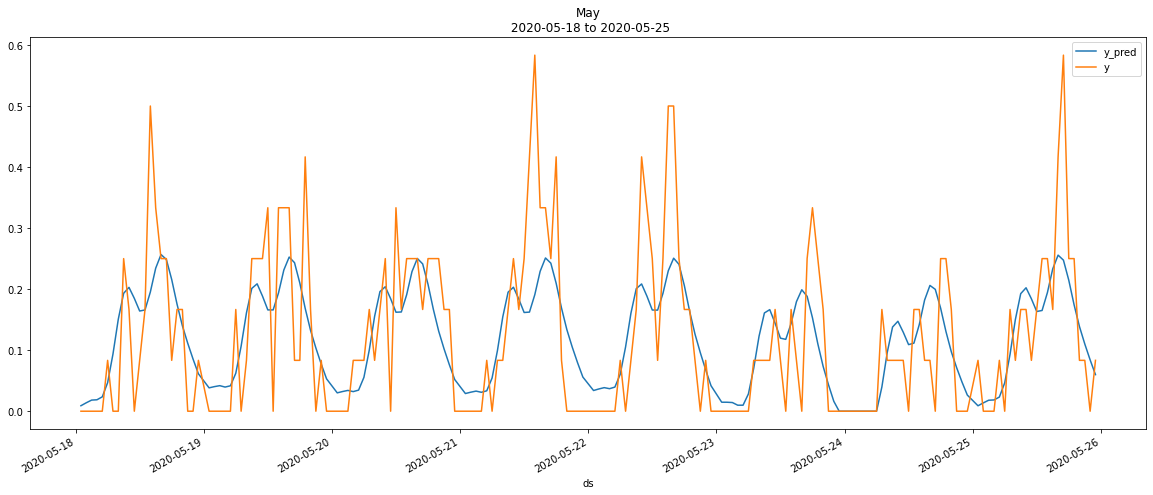

In [44]:
init_date = '2020-05-18'
end_date = '2020-05-25'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May\n %s to %s'%(init_date, end_date))

### Plots per day

Text(0.5, 1.0, 'May: monday\n 2020-05-04 01:00:00 to 2020-05-04 23:00:00')

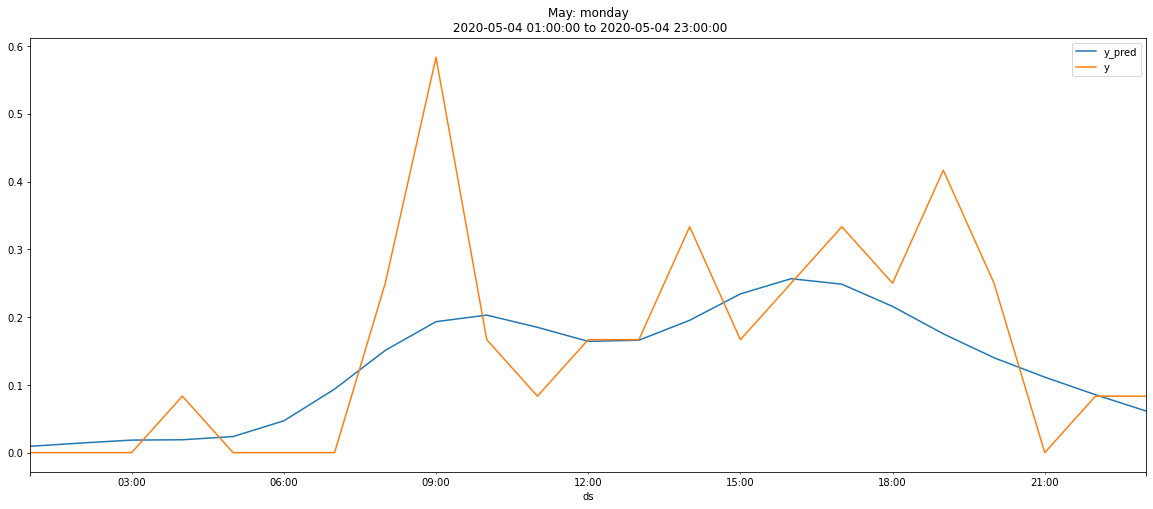

In [45]:
init_date = '2020-05-04 01:00:00'
end_date = '2020-05-04 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: monday\n %s to %s'%(init_date, end_date))

Text(0.5, 1.0, 'May: tuesday\n 2020-05-05 01:00:00 to 2020-05-05 23:00:00')

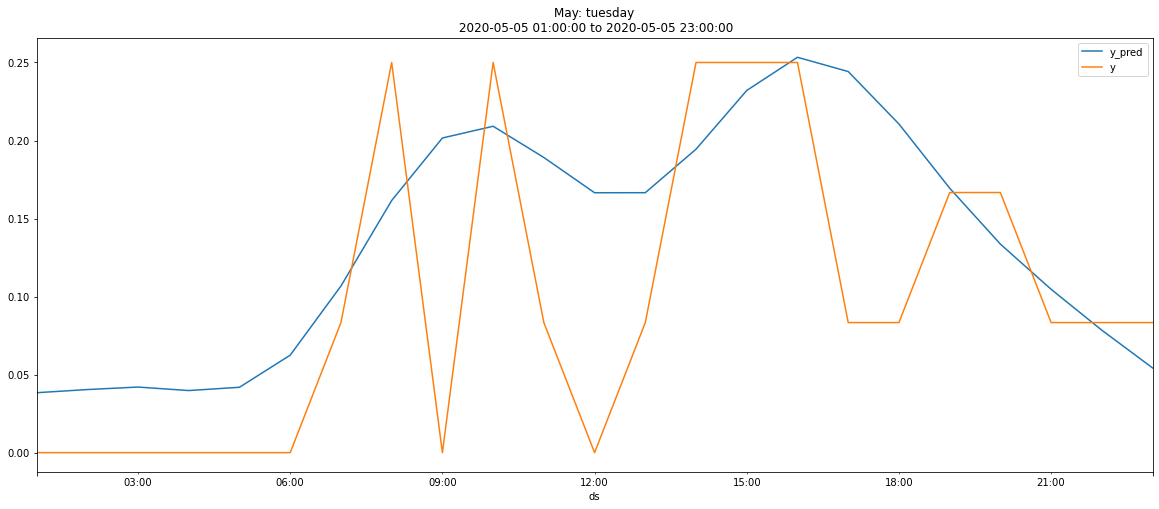

In [46]:
init_date = '2020-05-05 01:00:00'
end_date = '2020-05-05 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: tuesday\n %s to %s'%(init_date, end_date))

Text(0.5, 1.0, 'May: wednesday\n 2020-05-06 01:00:00 to 2020-05-06 23:00:00')

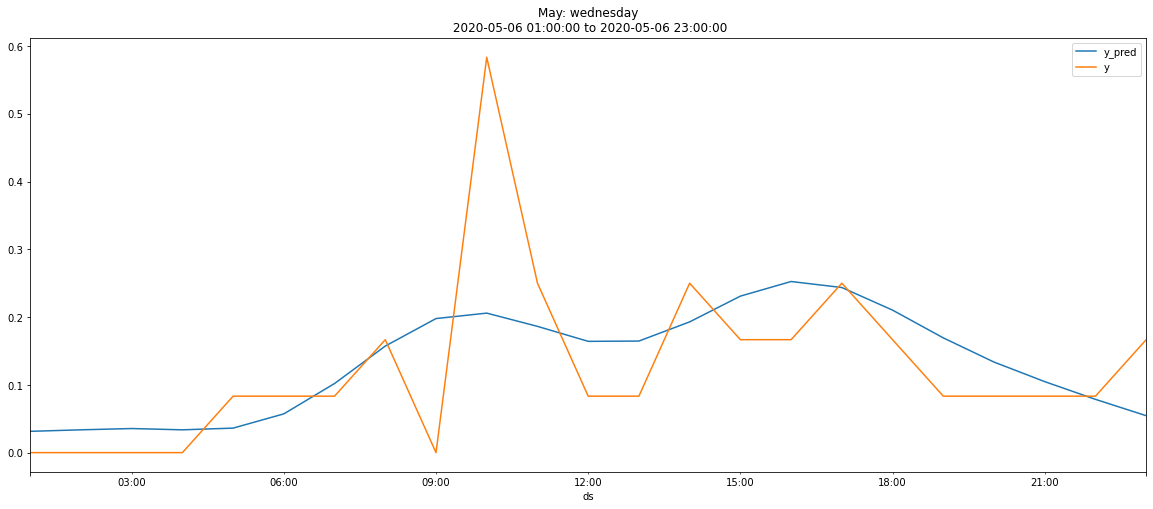

In [47]:
init_date = '2020-05-06 01:00:00'
end_date = '2020-05-06 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: wednesday\n %s to %s'%(init_date, end_date))

Text(0.5, 1.0, 'May: thursday\n 2020-05-07 01:00:00 to 2020-05-07 23:00:00')

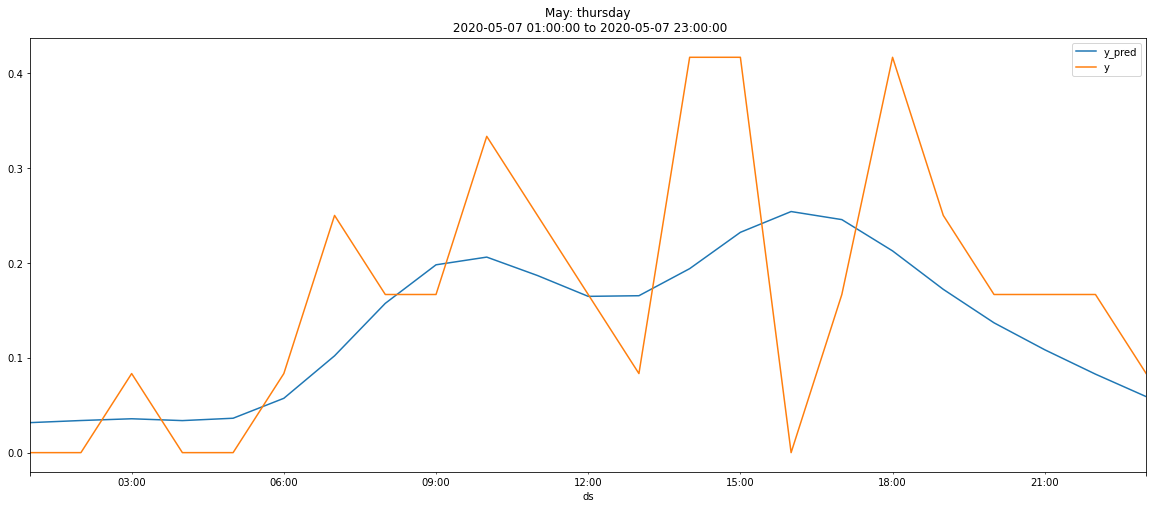

In [48]:
init_date = '2020-05-07 01:00:00'
end_date = '2020-05-07 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: thursday\n %s to %s'%(init_date, end_date))

Text(0.5, 1.0, 'May: friday\n 2020-05-08 01:00:00 to 2020-05-08 23:00:00')

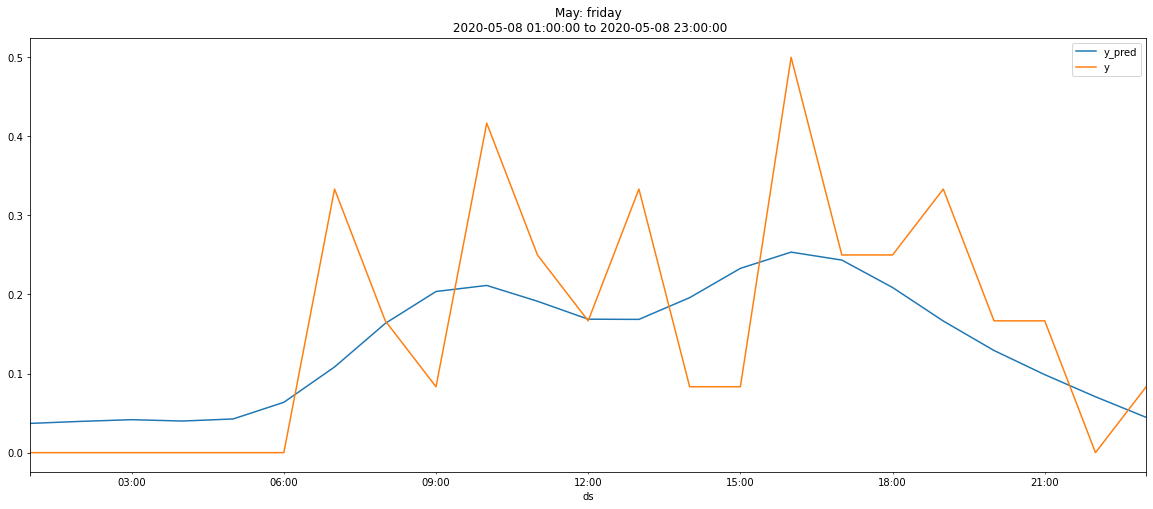

In [49]:
init_date = '2020-05-08 01:00:00'
end_date = '2020-05-08 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: friday\n %s to %s'%(init_date, end_date))

Text(0.5, 1.0, 'May: saturday\n 2020-05-09 01:00:00 to 2020-05-09 23:00:00')

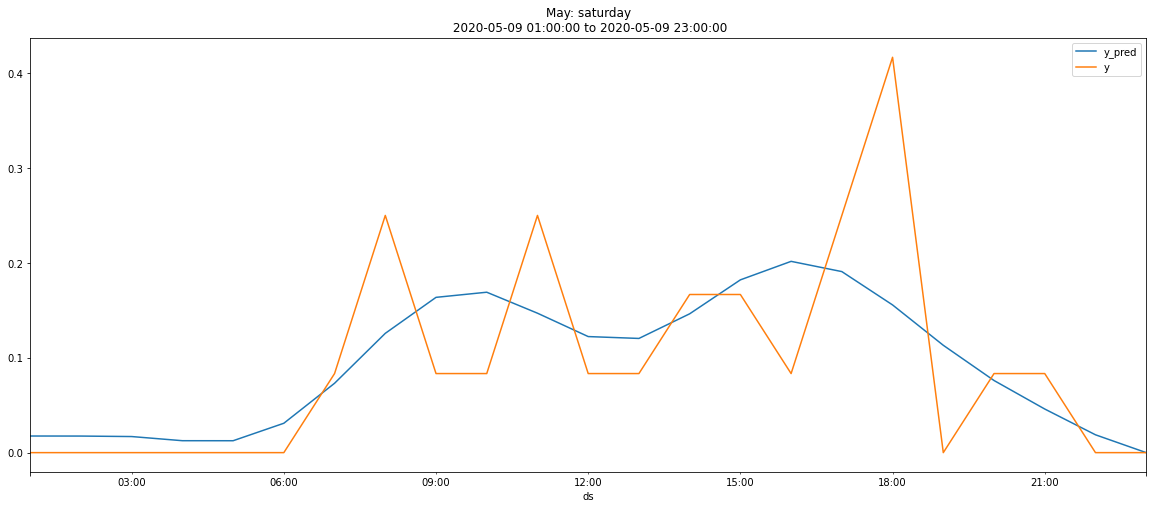

In [50]:
init_date = '2020-05-09 01:00:00'
end_date = '2020-05-09 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: saturday\n %s to %s'%(init_date, end_date))

Text(0.5, 1.0, 'May: sunday\n 2020-05-10 01:00:00 to 2020-05-10 23:00:00')

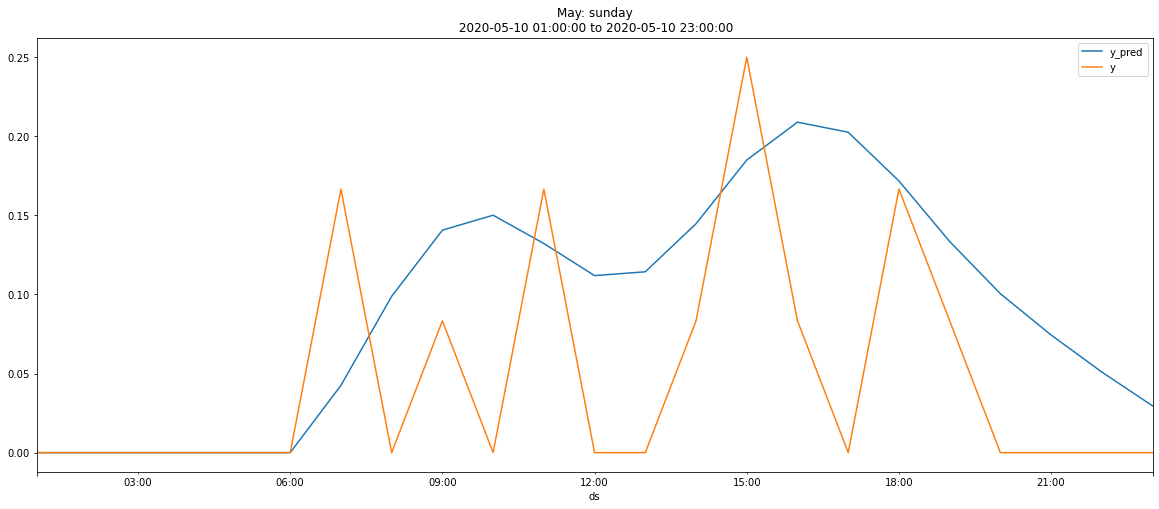

In [51]:
init_date = '2020-05-10 01:00:00'
end_date = '2020-05-10 23:00:00'
ax_aug=y_pred_df_site[init_date:end_date].plot(x='ds',y='yhat',legend=True,label='y_pred',figsize=(20,8))
y_true_df_site[init_date:end_date].plot(x='ds',y='y',legend=True,label='y',ax=ax_aug)
plt.title('May: sunday\n %s to %s'%(init_date, end_date))

# Save model and exec times to serialized file

In [ ]:
filename = 'groupsforecasting_exectimes_overalltime_v1.pkl'
pickle.dump([groups_info, exec_times_info, overall_exec_time], 
            open(PATH_SERIALIZER+filename,'wb'))